# **Shallow Vision Transformer(ViT) for Image Classification**

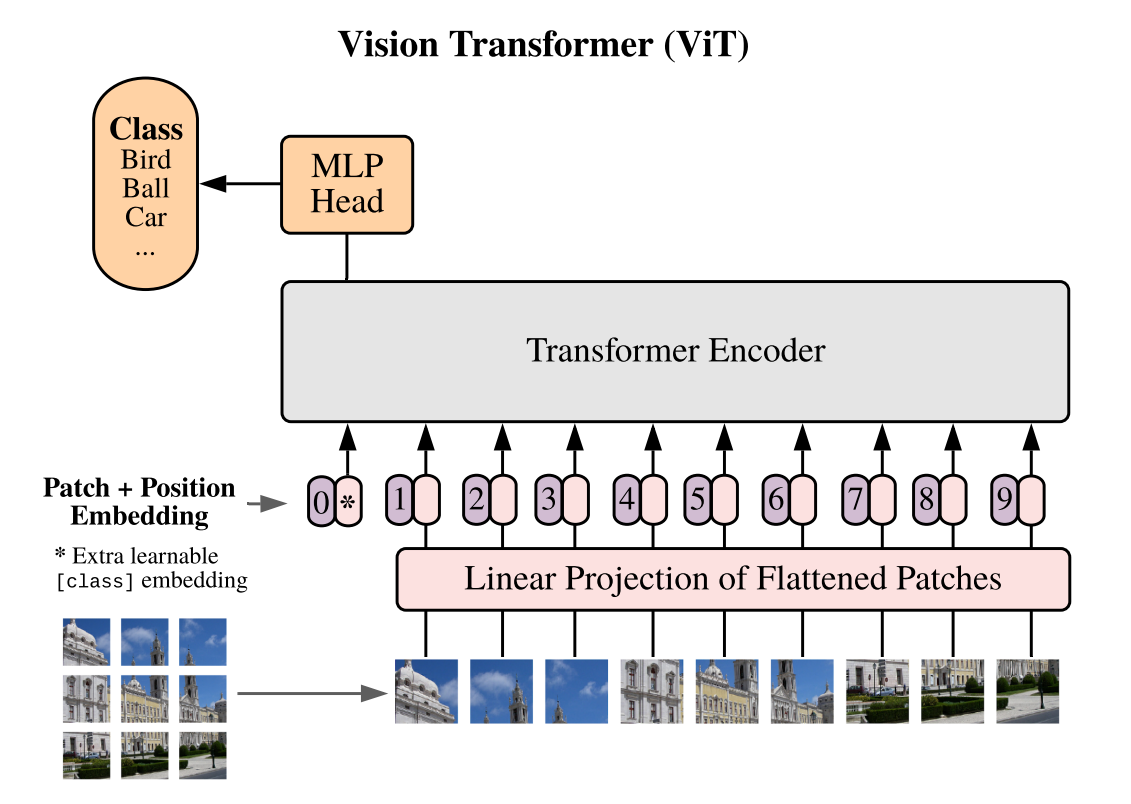

The **Transformer architecture**, introduced in the seminal paper **"Attention is All You Need" (Vaswani et al., 2017)**, revolutionized the **natural language processing (NLP)** landscape. The core innovation of this paper is the concept of **self-attention**, which enables the model to weigh different parts of an input sequence dynamically.  

However, prior to transformers, **Convolutional Neural Networks (CNNs)**—introduced in 1998 by **Yann LeCun**—were the industry standard for image processing tasks. CNNs leverage spatial hierarchies and local receptive fields to extract meaningful features from images.  

## **Vision Transformer (ViT)**  

In the 2021 paper **"An Image Is Worth 16x16 Words – Transformers for Image Recognition at Scale"**, researchers introduced the **Vision Transformer (ViT)**, which directly applied the **transformer architecture to image processing**. Unlike CNNs, which rely on convolutions, ViT **splits an image into patches**, flattens them, and feeds them into an **embedding layer**.  

### **Key Differences Between CNNs and ViT**  

- **Self-Attention as a Set Operator**:  
  Unlike CNNs, transformers do not inherently preserve spatial relationships. **Self-attention treats inputs as an unordered set**, ignoring the natural order unless explicitly encoded.  

- **Positional Encoding**:  
  - In the original Transformer (Vaswani et al., 2017), a mix of **sine and cosine functions** was used for **positional encoding**.  
  - In **ViT**, the explicit positional encoding is replaced by a **learnable embedding layer** that captures spatial relationships dynamically.  

- **Inductive Bias and Generalization**:  
  - **CNNs process images in a spatially constrained manner**, making them highly specialized for vision tasks.  
  - **ViT, with its lower inductive bias, performs a more generalized processing of visual inputs**, relying on large-scale datasets to learn spatial dependencies.  

The introduction of **ViT** marked a paradigm shift in **computer vision**, demonstrating that **self-attention-based models can match or even surpass CNNs** in various image recognition tasks, given sufficient data and computational resources.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


In [2]:

n_embd = 32
dropout = 0.2
block_size = 16
img_vec_size = 10

## **A single head of attention**

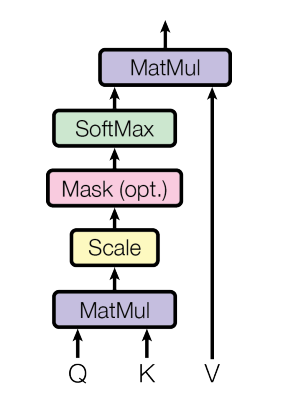


**Self-attention** operates using three key matrices:  

- **Query (Q)**  
- **Key (K)**  
- **Value (V)**  

These matrices **map the embeddings into a lower-dimensional subspace**, allowing the model to dynamically focus on different parts of the input.  

### **How Self-Attention Works**  

1. Compute the **dot product** between each **query** and **key**:  
   - The **query** acts as a question.  
   - The **key** serves as a potential answer.  

2. Apply **softmax** to these dot products to generate the attention weights.  

3. Compute the **weighted sum** of the values (**V**), where:  
   - **Values encode the embeddings** and act as a **signaling mechanism** for the model.  

### **Mathematical Formulation**  

Self-attention can be written as:

.


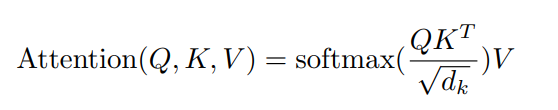

- \( Q, K, V \) are the **query**, **key**, and **value** matrices, respectively.  
- \( dk \) is the **dimensionality of the key vectors**, used for scaling.  
- Softmax ensures the attention scores sum to **1**, making them interpretable as probabilities.  

This mechanism allows transformers to **dynamically assign importance to different parts of the input**, improving their ability to model complex relationships


In [3]:
class Head(nn.Module):
  ''' One head of self-attention '''
  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(n_embd, head_size, bias = False)
    self.query = nn.Linear(n_embd, head_size, bias = False)
    self.value = nn.Linear(n_embd, head_size, bias = False)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B,T,C = x.shape
    k = self.key(x)
    q = self.query(x)

    #compute attention scores
    wei = q @ k.transpose(-2,-1) * C**(-0.5)
    wei = F.softmax(wei, dim=-1)
    wei = self.dropout(wei)

    #perform weighted aggregation of the values
    v = self.value(x)
    out = wei @ v

    return out

## **Multi-headed attention**

To enhance the model’s ability to capture diverse relationships within the input, we use **multiple self-attention heads in parallel**, forming the **multi-head attention module**.  

### **Why Multi-Head Attention?**  

- Each **self-attention head** learns **different contextual information** from the input.  
- By processing the data through multiple attention heads **simultaneously**, the model captures **a richer representation** of the input features.  



### **Benefits of Multi-Head Attention**  

**Captures multiple perspectives**: Different heads focus on different relationships in the data.  
**Enhances feature extraction**: Helps in learning **both local and global dependencies**.  
**Improves robustness**: Reduces over-reliance on any single attention pattern.  

By leveraging **multi-head attention**, **Vision Transformers (ViTs)** can extract diverse contextual information from an image, improving overall model performance.


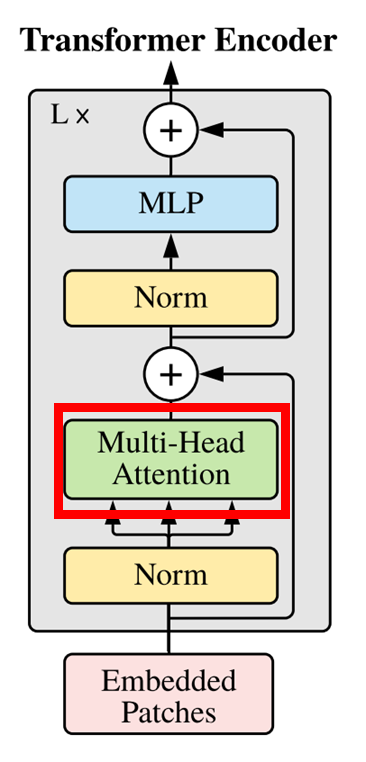

In [4]:
class MultiHeadAttention(nn.Module):
  ''' Multiple heads of self-attention in parallel '''
  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd, n_embd)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out

## **Multi-Layer Perceptron (MLP)**

While **self-attention** acts as a **communication mechanism**, the **Multi-Layer Perceptron (MLP) block** allows the encoder to:  

**Process** information  
**Think** by transforming learned representations  
**Store** knowledge across layers  

### **MLP in Transformer Models**  

In modern transformer architectures, a significant portion of the **model parameters** is concentrated in these **MLP layers**. This is because:  

- The **MLP expands and refines** the feature representations extracted by self-attention.  
- It enables **non-linear transformations**, allowing the model to **learn complex patterns**.  
- The **feed-forward structure** helps retain and propagate information efficiently across layers.  

### **MLP Block Structure in Transformers**  

A typical **MLP block** consists of:  

1. **Linear transformation** (Fully Connected Layer)  
2. **Activation function** (usually GELU or ReLU)  GELU is used in modern transfomer architectures such as GPT-2, and GPT-3
3. **Dropout** (to improve generalization)  
4. **Another Linear transformation**  



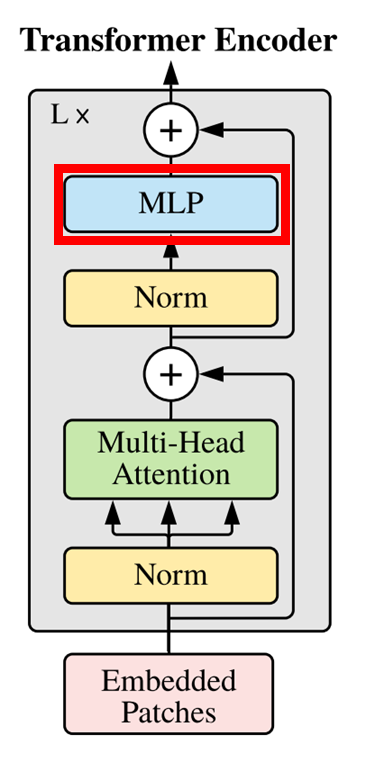

In [5]:
class FeedForward(nn.Module):
  '''A simple linear layer followed by a non-linearity'''
  def __init__(self, n_embd):
    super().__init__()
    self.net=nn.Sequential(
      nn.Linear(n_embd, 4 * n_embd),
      nn.ReLU(),
      nn.Linear(4 * n_embd, n_embd),
      nn.Dropout(dropout),
    )

  def forward(self,x):
    return self.net(x)

## **Encoder Block**

In the **encoder block**, we integrate:  

- **Multi-Head Self-Attention** (MHA)  
- **Multi-Layer Perceptron (MLP)**  

to create a **single uniform unit** that efficiently processes input representations.  

### **Residual Connections for Stability**  

To improve **gradient flow** and **optimization**, we introduce **residual connections**, as proposed in the paper: Deep Residual Learning for Image Recognition (He et al., 2015)  

These **skip connections** help prevent the **vanishing gradient problem** and allow deeper networks to train effectively.  

### **Layer Normalization (LayerNorm)**  

In transformer-based architectures, **Layer Normalization (LayerNorm)** is applied to stabilize training.  

 **Key Difference Between ViT and the Original Transformer:**  
- **Original Transformer (Vaswani et al., 2017)**:  
  - **LayerNorm was applied *after* MHA and MLP.**  
- **Vision Transformer (ViT, 2021)**:  
  - **LayerNorm is applied *before* MHA and MLP.**  



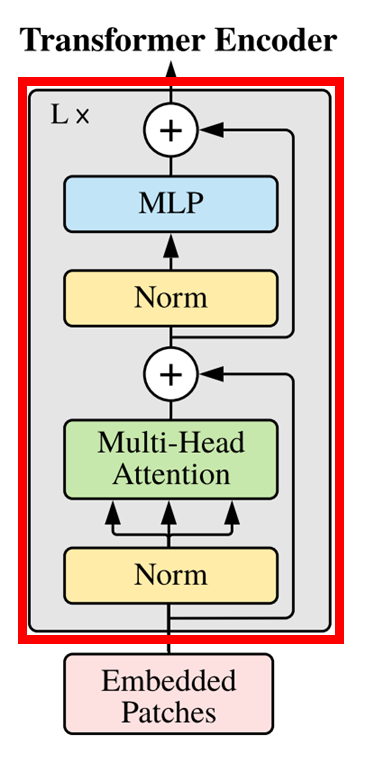

In [6]:
class Block(nn.Module):
  def __init__(self,n_embd,n_head):
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head,head_size)
    self.ffwd = FeedForward(n_embd)
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self,x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x

## **Vision Transformer (ViT)**

In this implementation, we use a **shallow Vision Transformer (ViT)** with **3 encoder blocks** to classify MNIST images.  

### **Patch Embedding Strategy**  

- Each **MNIST image (28×28)** is split into **16 patches of size 7×7**.  
- Each **patch is flattened** and passed through an **embedding layer** to create **patch embeddings**.  

### **Classification Strategy**  

- Instead of using a **[CLS] token**, we **use the first token itself for classification**, simplifying the implementation.  

### **Positional Embeddings**  

- Since transformers **do not inherently capture spatial order**, we **add positional embeddings** to the **patch embeddings**.  
- This helps the model retain information about **relative positions** within the image.  



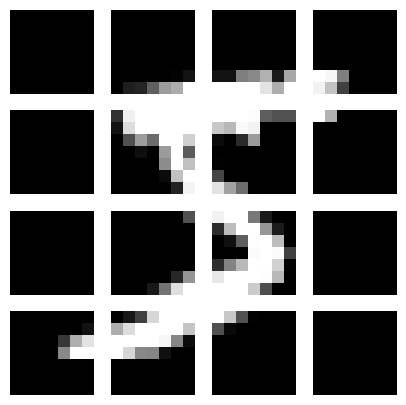

In [7]:
class VisionTransformer(nn.Module):
    def __init__(self, img_vec_size, n_embd, block_size=16):
        super().__init__()
        self.encoder = nn.Linear(49, 32)
        self.pos_embedding = nn.Linear(49, 32)
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4)
        )
        self.ln_f = nn.LayerNorm(n_embd)
        self.vit_head = nn.Linear(n_embd, 10)

    def forward(self, imgs):
        patch_size = 7
        imgs_patches = imgs.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        imgs_patches = imgs_patches.contiguous().view(64, 16, 49)
        x = self.encoder(imgs_patches)
        x = x + self.pos_embedding(imgs_patches)
        x = self.blocks(x)
        x = self.ln_f(x)
        x = self.vit_head(x)
        x = x[:, 0]  # Use first token for classification
        x = torch.softmax(x, dim=1)
        return x


## **Train loop**

Epoch [1/20] Training Accuracy: 47.76%
Epoch [2/20] Training Accuracy: 66.95%
Epoch [3/20] Training Accuracy: 72.08%
Epoch [4/20] Training Accuracy: 76.17%
Epoch [5/20] Training Accuracy: 78.80%
Epoch [6/20] Training Accuracy: 80.94%
Epoch [7/20] Training Accuracy: 82.42%
Epoch [8/20] Training Accuracy: 83.42%
Epoch [9/20] Training Accuracy: 84.38%
Epoch [10/20] Training Accuracy: 84.96%
Epoch [11/20] Training Accuracy: 85.64%
Epoch [12/20] Training Accuracy: 86.06%
Epoch [13/20] Training Accuracy: 86.56%
Epoch [14/20] Training Accuracy: 86.98%
Epoch [15/20] Training Accuracy: 87.44%
Epoch [16/20] Training Accuracy: 87.44%
Epoch [17/20] Training Accuracy: 87.73%
Epoch [18/20] Training Accuracy: 88.05%
Epoch [19/20] Training Accuracy: 88.27%
Epoch [20/20] Training Accuracy: 88.35%


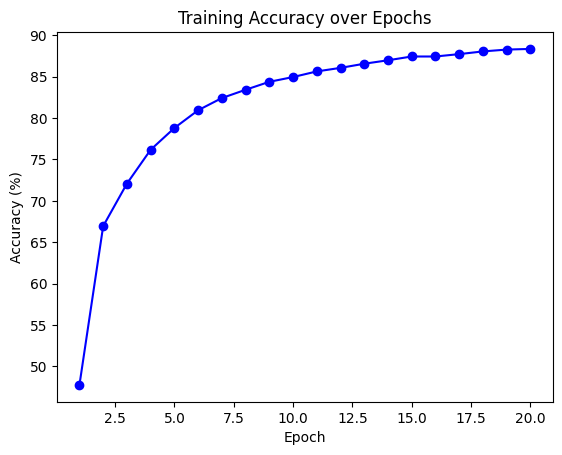

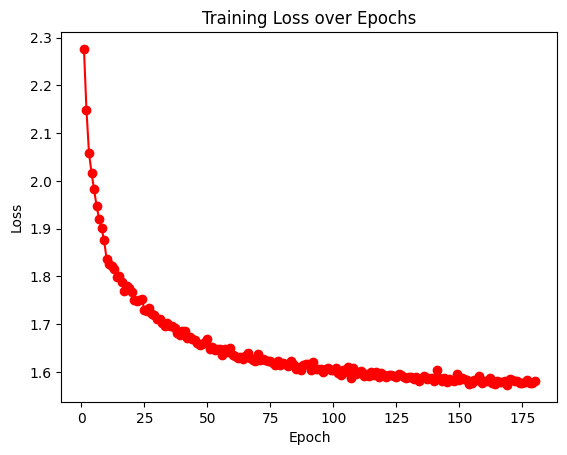

In [9]:
# Load MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)

# Initialize the VisionTransformer model
img_vec_size = 49  # 7x7 patch flattened
n_embd = 32        # Embedding dimension

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VisionTransformer(img_vec_size, n_embd).to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Initialize list to track accuracy for plotting
train_accuracies = []

losses = []

# Training loop for a few epochs
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader, 1):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()        # Backpropagate the loss

        # Update weights
        optimizer.step()

        # Calculate accuracy for this batch
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print loss every 100 batches
        running_loss += loss.item()
        if i % 100 == 0:
            avg_loss = running_loss / 100
            #print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}/{len(train_loader)}], Loss: {avg_loss:.4f}")
            running_loss = 0.0
            losses.append(avg_loss)
    # Calculate epoch training accuracy
    epoch_accuracy = 100 * correct / total
    train_accuracies.append(epoch_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}] Training Accuracy: {epoch_accuracy:.2f}%")
torch.save(model.state_dict(), "vision_transformer.pth")
# Plot training accuracy
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', linestyle='-', color='b')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

# Plot training loss
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='r')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()




In [10]:
# Calculate test accuracy
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to compute gradients for testing
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 90.65%
